In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model
from fourparam_fit import xi_bestfit, fit_to_cf_model

In [2]:
# Y = A M
# where Y = data vector (dependent), A = features (including IVs), M = best-fit parameters (m & b / or B^2, a1, a2, a3)
# keep in mind, we do this fit for each mock

In [3]:
# define r vector
rmin = 20.0
rmax = 140.0
nbins = 22
r_edges = np.linspace(rmin, rmax, nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])
len(r_avg)

22

### Y vector

In [4]:
# results of L-S estimator on entire mock (i.e. no patches)
# for now, arbitrary numbers
Y = np.ones(nbins)
print(Y.shape)

(22,)


### A matrix (features)

In [5]:
# xi_mod
alpha = 1.0
xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)

In [6]:
A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
print(A.shape)

(22, 4)


### C matrix (covariance)

In [7]:
# ones for now
C = np.identity(len(Y))
C_inv = np.linalg.inv(C)

### least squares fit: Y = A @ X

In [8]:
M = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
print(M.shape, M)

(4,) [-1.45519152e-11  1.86264515e-09 -1.45519152e-11  1.00000000e+00]


In [9]:
# these are our best-fit parameters: B**2, a1, a2, a3

# real data!

### load in data

In [10]:
data_dir = '/scratch/aew492/research-summer2020_output'
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
rlz = 0
m = 1
b = 0.5
mock_name = f'{cat_tag}_rlz{rlz}_lognormal'

In [11]:
# results of L-S estimator on entire mock (i.e. no patches)
# xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{mock_name}.npy'), allow_pickle=True)
print(xi_ls.shape)

(2, 22)


In [12]:
r_avg = xi_ls[0]

### Landy-Szalay results (Y vector)

In [13]:
Y = xi_ls[1]
print(Y.shape)

(22,)


### feature (A) matrix

In [14]:
# xi_mod
alpha = 1.0
xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)

In [15]:
A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
print(A.shape)

(22, 4)


### covariance (C) matrix

In [16]:
# ones for now
C = np.identity(len(Y))
C_inv = np.linalg.inv(C)

### performing the fit: finding best-fit parameters for given alpha

In [17]:
X = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
B_sq, a1, a2, a3 = X
print(X.shape, X)

(4,) [ 2.85051664e+00 -1.15992819e+02  1.95415146e+00 -9.11522662e-03]


In [18]:
# putting X values back into equation for xi_fit— but we'll use a finer r grid for a smoother plot
ncont = 1000
r_avg_fine = np.linspace(rmin, rmax, ncont+1)
xi_mod_fine = cf_model(alpha*r_avg_fine, cosmo_base=None, redshift=0.57, bias=2.0)

xi_fit = B_sq*xi_mod_fine + a1/r_avg_fine**2 + a2/r_avg_fine + a3
xi_fit.shape

(1001,)

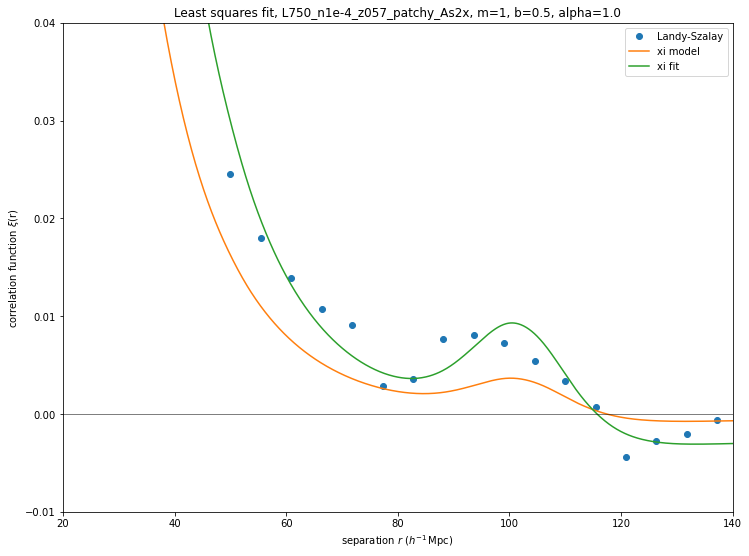

In [19]:
# visualization
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, Y, marker='o', linestyle='None', label='Landy-Szalay')
plt.plot(r_avg_fine, xi_mod_fine, label='xi model')
plt.plot(r_avg_fine, xi_fit, label='xi fit')

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Least squares fit, {cat_tag}, m={m}, b={b}, alpha={alpha}')
plt.legend()

## functions + multiple alpha values

In [20]:
# we do this for a bunch of different alpha values:
def lst_sq_fit(alpha, xi_ls, cov=None):
    r_avg = xi_ls[0]
    nbins = len(r_avg)
    Y = xi_ls[1]
    xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)
    A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
    
    if cov==None:
        C = np.identity(len(Y))
        C_inv = np.linalg.inv(C)
    else:
        assert False, "covs must be 1 for now"
    
    X = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
    B_sq, a1, a2, a3 = X
    
    xi_fit = B_sq*xi_mod + a1/r_avg**2 + a2/r_avg + a3
    
    return xi_fit

In [21]:
xi_fit = lst_sq_fit(1.0, xi_ls)

In [22]:
alpha_grid = np.linspace(0.75, 1.25, 51)
nalphas = len(alpha_grid)

In [23]:
alpha_grid

array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07,
       1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18,
       1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25])

In [24]:
data_dir = '/scratch/aew492/research-summer2020_output'
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
rlz = 0
m = 1
b = 0.5
xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
nbins = len(xi_ls[0])

In [25]:
xi_fits = np.empty((nalphas, nbins))
for i in range(nalphas):
    xi_fit = lst_sq_fit(alpha_grid[i], xi_ls)
    xi_fits[i] = xi_fit

In [26]:
xi_fits.shape, len(xi_fits[0])

((51, 22), 22)

In [27]:
# chi-squared test: find the alpha which minimizes chi-squared
chi_squared = np.sum((xi_ls[1] - xi_fits[0])**2 / xi_fits[0])

In [28]:
chi_squared

-4.978696155846698

In [29]:
chi_squareds = np.ones(nalphas)
for i in range(nalphas):
    diff = xi_ls[1] - xi_fits[i]
    chi_squared = np.dot(diff, np.linalg.solve(C, diff)) #***
    chi_squareds[i] = chi_squared

In [30]:
chi_squareds

array([1.80404978e-04, 1.80516860e-04, 1.80578506e-04, 1.80602915e-04,
       1.80605068e-04, 1.80600761e-04, 1.80601567e-04, 1.80605858e-04,
       1.80588614e-04, 1.80490690e-04, 1.80219224e-04, 1.79653547e-04,
       1.78643464e-04, 1.77015918e-04, 1.74607297e-04, 1.71283890e-04,
       1.66957492e-04, 1.61609615e-04, 1.55329373e-04, 1.48284824e-04,
       1.40648452e-04, 1.32629087e-04, 1.24509681e-04, 1.16619444e-04,
       1.09204044e-04, 1.02433207e-04, 9.64106045e-05, 9.12264893e-05,
       8.70043572e-05, 8.38293487e-05, 8.17142644e-05, 8.05934073e-05,
       8.03346285e-05, 8.08167049e-05, 8.20072994e-05, 8.38891564e-05,
       8.64221606e-05, 8.95361087e-05, 9.31338839e-05, 9.71254237e-05,
       1.01480218e-04, 1.06170107e-04, 1.11141551e-04, 1.16319722e-04,
       1.21613798e-04, 1.26926067e-04, 1.32179886e-04, 1.37327599e-04,
       1.42326456e-04, 1.47121313e-04, 1.51649701e-04])

Text(0.5, 1.0, 'Chi-squared, L750_n1e-4_z057_patchy_As2x, m=1, b=0.5, range of alphas')

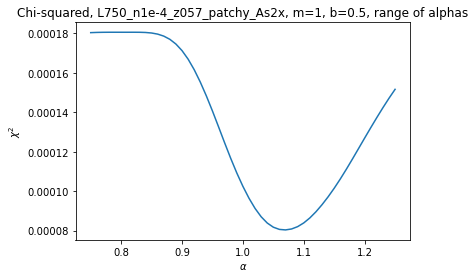

In [31]:
fig, ax = plt.subplots()

plt.plot(alpha_grid, chi_squareds)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.set_title(f'Chi-squared, {cat_tag}, m={m}, b={b}, range of alphas')

## checking results

In [32]:
rlz = 4
m = m
b = b

In [33]:
# Landy-Szalay
xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
r_avg = xi_ls[0]
ls_results = xi_ls[1]
print(xi_ls.shape)

(2, 22)


In [34]:
# 4-parameter fit
results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_gradient_{cat_tag}/basis_gradient_{cat_tag}_rlz{rlz}_m-1.000-L_b-0.500.npy'), allow_pickle=True).item()
B_sq = results['B_sq']
a1 = results['a1']
a2 = results['a2']
a3 = results['a3']
alpha = results['best_alpha']
alpha, B_sq, a1, a2, a3, B_sq.shape

(0.834,
 -0.3581626203594109,
 166.65780814726725,
 -2.308306702551606,
 0.008047938398498345,
 ())

In [35]:
# plug recovered parameters back into xi equation
ncont = 1000
r_fine = np.linspace(rmin, rmax, ncont+1)
xi_mod_fine = cf_model(alpha*r_fine, cosmo_base=None, redshift=0.57, bias=2.0)

xi_fit = xi_bestfit(r_fine, xi_mod_fine, B_sq, a1, a2, a3)
xi_fit.shape

(1001,)

## comparing standard fit results to bao_iterative results

In [36]:
# load in bao iterative
bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_gradient_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_m-{m}.000-L_b-{b}00_rlz{rlz}.npy'), allow_pickle=True)
rcont, bao_basis, _, _, extra_dict = bao_results
bao_alpha = extra_dict['alpha_model']


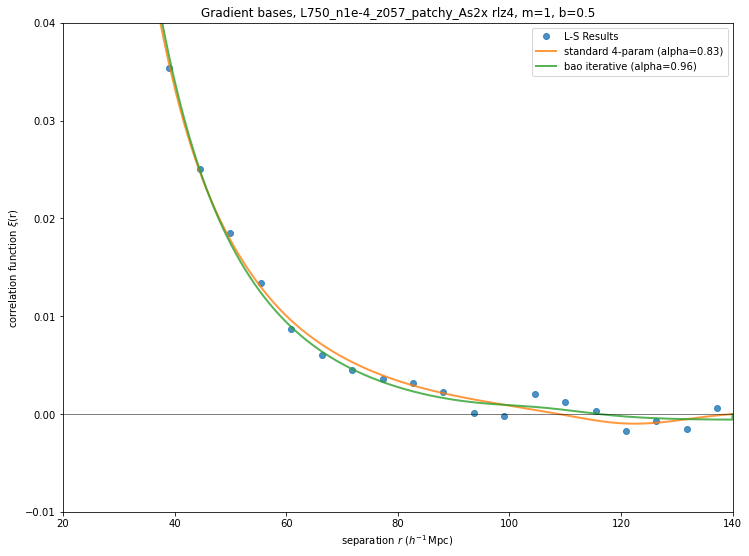

In [37]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, ls_results, marker='o', ls='None', alpha=0.8, label=f'L-S Results')

plt.plot(r_fine, xi_fit, lw=2, alpha=0.8, label='standard 4-param (alpha={:.2f})'.format(alpha))

plt.plot(rcont, bao_basis, lw=2, alpha=0.8, label='bao iterative (alpha={:.2f})'.format(bao_alpha))

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Gradient bases, {cat_tag} rlz{rlz}, m={m}, b={b}')
plt.legend()

In [38]:


chi_squareds = np.ones(nalphas)
for i in range(nalphas):
    diff = xi_ls[1] - xi_fits[i]
    chi_squared = np.dot(diff, np.linalg.solve(C, diff)) #***
    chi_squareds[i] = chi_squared

### average over all mocks

In [39]:
nmocks = 401
nbins = 22

In [40]:
# Landy-Szalay
xi_lss = np.empty((nmocks, nbins))
for rlz in range(nmocks):
    xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
    r_avg = xi_ls[0]
    xi_lss[rlz] = xi_ls[1]

In [41]:
# 4-parameter fit bases
ncont = 1000
r_fine = np.linspace(rmin, rmax, ncont+1)

xi_fits = np.empty((nmocks, ncont+1))
alpha_fits = np.ones(nmocks)
for rlz in range(nmocks):
    results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_gradient_{cat_tag}/basis_gradient_{cat_tag}_rlz{rlz}_m-1.000-L_b-0.500.npy'), allow_pickle=True).item()
    B_sq = results['B_sq']
    a1 = results['a1']
    a2 = results['a2']
    a3 = results['a3']
    alpha = results['best_alpha']
    
    xi_mod_fine = cf_model(alpha*r_fine, cosmo_base=None, redshift=0.57, bias=2.0)

    xi_fit = xi_bestfit(r_fine, xi_mod_fine, B_sq, a1, a2, a3)
    
    xi_fits[rlz] = xi_fit
    alpha_fits[rlz] = alpha

In [42]:
# bao iterative bases
ncont = 2000

xi_baoits = np.empty((nmocks, ncont))
alphas_baoits = np.ones(nmocks)
for rlz in range(nmocks):
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_gradient_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_m-{m}.000-L_b-{b}00_rlz{rlz}.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    alpha = extra_dict['alpha_model']
    
    xi_baoits[rlz] = bao_basis
    alphas_baoits[rlz] = alpha

In [43]:
# averages
ls_avg = np.mean(xi_lss, axis=0)
print(ls_avg.shape)
fit_avg = np.mean(xi_fits, axis=0)
print(fit_avg.shape)
baoits_avg = np.mean(xi_baoits, axis=0)
print(baoits_avg.shape)

(22,)
(1001,)
(2000,)


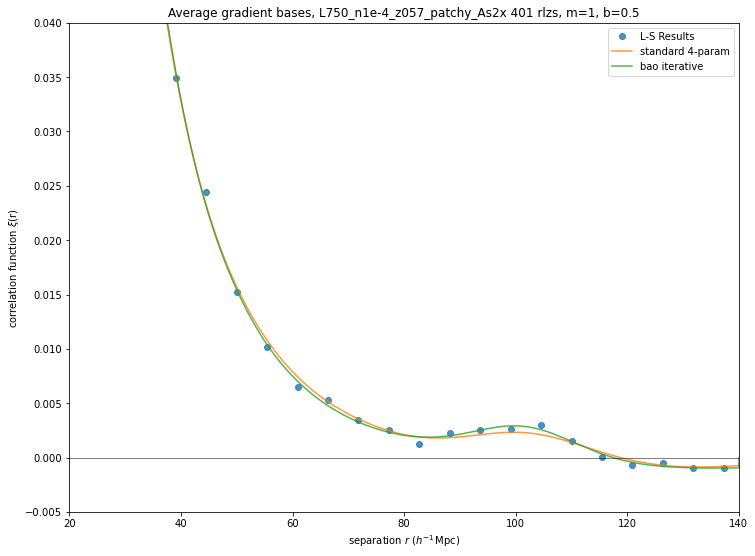

In [44]:
# plot
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, ls_avg, marker='o', ls='None', alpha=0.8, label=f'L-S Results')

plt.plot(r_fine, fit_avg, lw=1.5, alpha=0.8, label=f'standard 4-param')

plt.plot(rcont, baoits_avg, lw=1.5, alpha=0.8, label='bao iterative'.format(bao_alpha))

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Average gradient bases, {cat_tag} 401 rlzs, m={m}, b={b}')
plt.legend()

## lognormal bases results

### average over all mocks

In [45]:
nmocks = 401
nbins = 22

In [46]:
# Landy-Szalay
xi_lss = np.empty((nmocks, nbins))
for rlz in range(nmocks):
    xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = xi_ls[0]
    xi_lss[rlz] = xi_ls[1]

In [47]:
# 4-parameter fit bases
ncont = 1000
r_fine = np.linspace(rmin, rmax, ncont+1)

xi_fits = np.empty((nmocks, ncont+1))
alpha_fits = np.ones(nmocks)
for rlz in range(nmocks):
    results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    B_sq = results['B_sq']
    a1 = results['a1']
    a2 = results['a2']
    a3 = results['a3']
    alpha = results['best_alpha']
    
    xi_mod_fine = cf_model(alpha*r_fine, cosmo_base=None, redshift=0.57, bias=2.0)

    xi_fit = xi_bestfit(r_fine, xi_mod_fine, B_sq, a1, a2, a3)
    
    xi_fits[rlz] = xi_fit
    alpha_fits[rlz] = alpha

In [48]:
# bao iterative bases
ncont = 2000

xi_baoits = np.empty((nmocks, ncont))
alphas_baoits = np.ones(nmocks)
for rlz in range(nmocks):
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    alpha = extra_dict['alpha_model']
    
    xi_baoits[rlz] = bao_basis
    alphas_baoits[rlz] = alpha

In [49]:
alphas_baoits

array([1.02830509, 1.05180938, 0.99339124, 1.06608297, 0.97231794,
       0.99393713, 1.01669711, 0.97262893, 1.04175809, 0.99558191,
       0.97415788, 0.99967752, 0.99419225, 0.92979677, 1.05703536,
       1.17088997, 1.00116224, 0.98950682, 1.00342683, 1.03950816,
       1.00343967, 1.0682366 , 0.99398731, 0.97752113, 1.00061289,
       0.9926931 , 0.9850421 , 0.95145485, 0.94936164, 0.97677361,
       0.99172159, 0.96743836, 0.96507974, 0.99613763, 0.97994827,
       1.00664497, 0.96737343, 0.97668855, 1.01554287, 1.00450923,
       0.9794054 , 1.00762267, 0.99265487, 0.92116239, 1.0248796 ,
       0.97911485, 0.99076378, 1.04763272, 1.04875838, 0.99317423,
       1.01493122, 0.9650313 , 1.06151984, 0.97184095, 1.05226065,
       1.01118277, 1.01481835, 1.0296963 , 0.99999718, 1.01115185,
       1.00334564, 1.02828879, 1.00555977, 1.03075518, 0.97027956,
       0.98993391, 0.96250419, 0.96916755, 0.98059661, 1.0335428 ,
       1.01066179, 1.02059126, 1.04345731, 1.00271763, 0.97294

In [50]:
# averages
ls_avg = np.mean(xi_lss, axis=0)
print(ls_avg.shape)
fit_avg = np.mean(xi_fits, axis=0)
print(fit_avg.shape)
baoits_avg = np.mean(xi_baoits, axis=0)
print(baoits_avg.shape)

(22,)
(1001,)
(2000,)


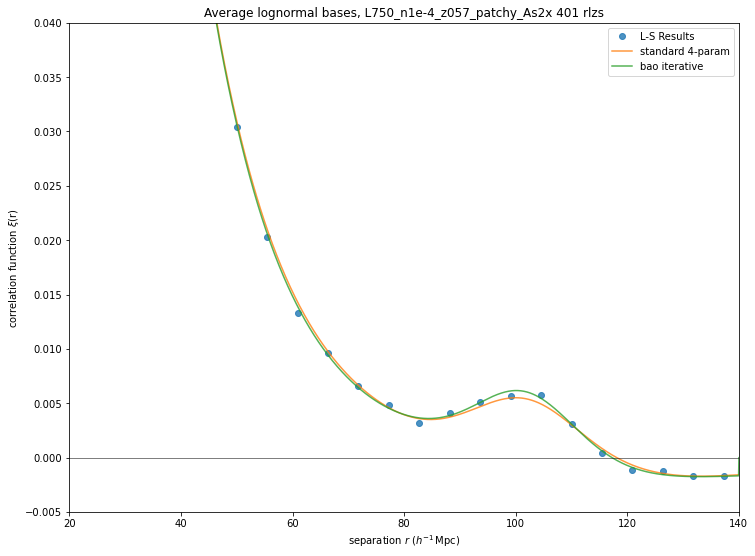

In [51]:
# plot
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, ls_avg, marker='o', ls='None', alpha=0.8, label=f'L-S Results')

plt.plot(r_fine, fit_avg, lw=1.5, alpha=0.8, label=f'standard 4-param')

plt.plot(rcont, baoits_avg, lw=1.5, alpha=0.8, label='bao iterative')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Average lognormal bases, {cat_tag} 401 rlzs')
plt.legend()

### patchify results

In [52]:
n_patches = 8
patch_results = np.load(os.path.join(data_dir, f'gradient/1D/patch_data/{cat_tag}/{n_patches}patches/{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True).item()

In [53]:
patch_results.keys()

dict_keys(['n_patches', 'patch_centers', 'r_avg', 'xi_patches', 'xi_patch_avg', 'xi_full', 'theta', 'b_fit', 'm_fit', 'grad_recovered'])

In [54]:
patch_results['grad_recovered'].shape

(3, 1)

In [55]:
cfe_results = np.load(os.path.join(data_dir, f'gradient/1D/suave_data/{cat_tag}/bao_iterative/{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True).item()
cfe_results.keys()

dict_keys(['grad_recovered', 'mean_sq_err', 'r_avg', 'amps', 'r_fine', 'xi_locs', 'proj_type', 'projfn', 'weight_type'])

In [56]:
cfe_results['grad_recovered']

array([ 3.02475639e-03, -2.36753083e-05,  9.96870403e-05])

In [57]:
n_patches = 8
rlzs = range(401)
grads_rec = np.empty((len(rlzs), 3))
for rlz in rlzs:
    patch_results = np.load(os.path.join(data_dir, f'gradient/1D/patch_data/{cat_tag}/{n_patches}patches/{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True).item()
    grads_rec[rlz] = patch_results['grad_recovered'].flatten()

In [58]:
grad_exp_x = m/(b*750)
print(grad_exp_x)
grads_rec_x = grads_rec[:,0]
grads_rec_x.shape

0.0026666666666666666


(401,)

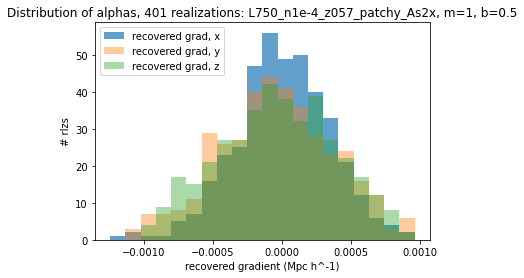

In [59]:
nbins = 20
alpha_x = 0.7
alpha_yz = 0.4
_, bins, _ = plt.hist(grads_rec_x - grad_exp_x, bins=nbins, alpha=alpha_x, label='recovered grad, x')
plt.hist(grads_rec[:,1], bins=bins, alpha=alpha_yz, label='recovered grad, y')
plt.hist(grads_rec[:,2], bins=bins, alpha=alpha_yz, label='recovered grad, z')
plt.xlabel('recovered gradient (Mpc h^-1)')
plt.ylabel('# rlzs')
plt.title(f'Distribution of alphas, 401 realizations: {cat_tag}, m={m}, b={b}')
plt.legend()

## distribution of alphas

In [60]:
# load in alpha values
rlzs = range(401)
standard_alphas = np.ones(len(rlzs))
bao_alphas = np.ones(len(rlzs))
for rlz in rlzs:
    standard_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_gradient_{cat_tag}/basis_gradient_{cat_tag}_rlz{rlz}_m-1.000-L_b-0.500.npy'), allow_pickle=True).item()
    standard_alpha = standard_results['best_alpha']
    standard_alphas[rlz] = standard_alpha
    
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_gradient_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_m-{m}.000-L_b-{b}00_rlz{rlz}.npy'), allow_pickle=True)
    _, _, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    bao_alphas[rlz] = bao_alpha

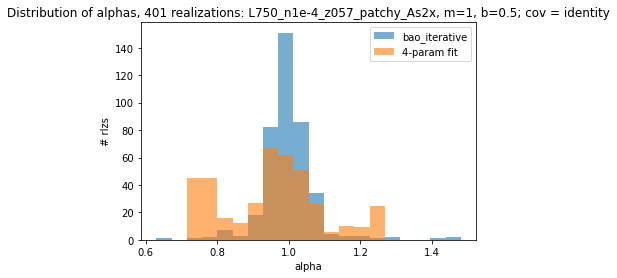

In [61]:
nbins = 20
alpha = .6
_, bins, _ = plt.hist(bao_alphas, bins=nbins, alpha=alpha, label='bao_iterative')
plt.hist(standard_alphas, bins=bins, alpha=alpha, label='4-param fit')
plt.xlabel('alpha')
plt.ylabel('# rlzs')
plt.title(f'Distribution of alphas, 401 realizations: {cat_tag}, m={m}, b={b}; cov = identity')
plt.legend()

## comparing our lstsq to scipy

In [62]:
# for one mock:
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
rlz = 0

# 4-parameter fit results
fit_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/full/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
B_sq = fit_results['B_sq']
a1 = fit_results['a1']
a2 = fit_results['a2']
a3 = fit_results['a3']
bestfit_alpha = fit_results['best_alpha']
bestfit_alpha, B_sq, a1, a2, a3, B_sq.shape

(1.04,
 2.4130547691568913,
 -42.69986911255914,
 0.9015217277467914,
 -0.003962542365461597,
 ())

### scipy.optimize

In [63]:
# binned results
ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
r_avg = ls_results[0]
xi_ls = ls_results[1]

# uncertainties:
# scipy.optimize can only take in a 1D sigma array as opposed to a full covariance matrix
nmocks = 401
nbins = len(r_avg)
xi_lss = np.empty((nmocks, nbins))
for rlz in range(nmocks): 
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_lss[rlz] = ls_results[1]
cov = np.cov(xi_lss.T)
print(cov.shape)

(22, 22)


In [64]:
# scipy.optimize.curve_fit(func, xdata, ydata, x0, sigma)
# the function we want to fit to is xi_bestfit (imported from fourparam_fit.py); but to fit the right form for the fit,
#    we need to define xi_mod separately instead of calling it as a parameter

def func(r, B_sq, a1, a2, a3):
    alpha = bestfit_alpha
    xi_mod = cf_model(alpha*r, cosmo_base=None, redshift=0.57, bias=2.0)
    
    xi_bestfit = B_sq*xi_mod + a1/r**2 + a2/r + a3
    return xi_bestfit

p0 = np.array([B_sq, a1, a2, a3])

scipy_params, _ = scipy.optimize.curve_fit(func, r_avg, xi_ls, p0=p0, sigma=cov)

In [65]:
scipy_params

array([ 2.41305477e+00, -4.26998691e+01,  9.01521728e-01, -3.96254237e-03])

In [66]:
B_sq_s, a1_s, a2_s, a3_s = scipy_params
scipy_fit = func(r_fine, B_sq_s, a1_s, a2_s, a3_s)

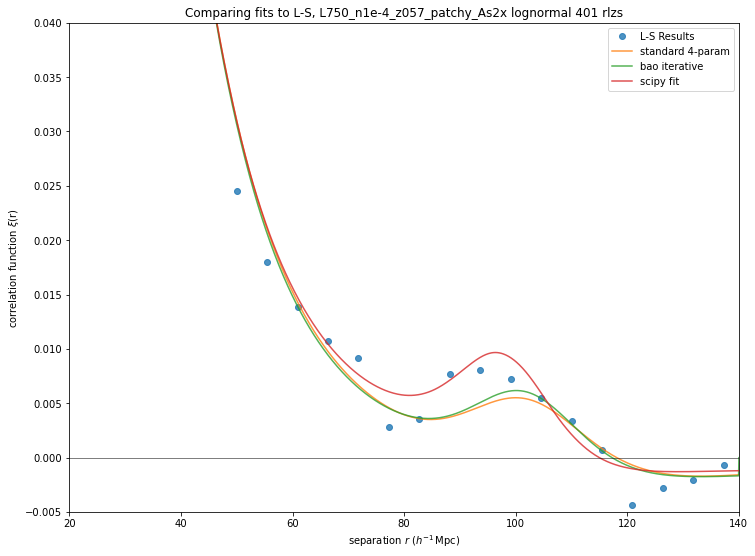

In [67]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, xi_ls, marker='o', ls='None', alpha=0.8, label=f'L-S Results')
plt.plot(r_fine, fit_avg, lw=1.5, alpha=0.8, label=f'standard 4-param')
plt.plot(rcont, baoits_avg, lw=1.5, alpha=0.8, label='bao iterative')
plt.plot(r_fine, scipy_fit, alpha=0.8, label='scipy fit')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Comparing fits to L-S, {cat_tag} lognormal 401 rlzs')
plt.legend()

## excluding outer bins

In [68]:
cut_size = 2
r_avg_cut = r_avg[cut_size:nbins-cut_size]
xi_ls_cut = xi_ls[cut_size:nbins-cut_size]
nbins_cut = len(r_avg_cut)

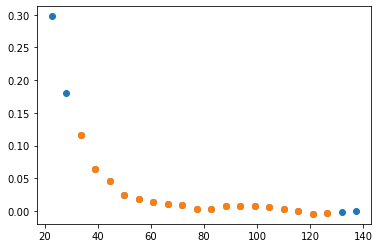

In [69]:
plt.plot(r_avg, xi_ls, marker='o', ls='None')
plt.plot(r_avg_cut, xi_ls_cut, marker='o', ls='None')

In [70]:
# new covariance matrix ?
xi_lss_cut = np.empty((nmocks, nbins_cut))
for rlz in range(nmocks):
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)

    r_avg_cut = ls_results[0][cut_size:nbins-cut_size]
    xi_lss_cut[rlz] = ls_results[1][cut_size:nbins-cut_size]

cov_cut = np.cov(xi_lss_cut.T)

In [71]:
# performing the fit

alpha_grid = np.linspace(0.75, 1.25, 501)
xi_fits = np.empty((len(alpha_grid), nbins))
xi_fits_cut = np.empty((len(alpha_grid), nbins_cut))
chi_squareds_cut = np.ones(len(alpha_grid))
chi_squareds = np.ones(len(alpha_grid))
for i in range(len(alpha_grid)):
    # excluding bins
    xi_fit_cut, M_cut = fit_to_cf_model(alpha_grid[i], xi_ls_cut, r_avg_cut, cov_cut)
    xi_fits_cut[i] = xi_fit_cut
    diff_cut = xi_ls_cut - xi_fit_cut
    chi_squared_cut = np.dot(diff_cut, np.linalg.solve(cov_cut, diff_cut))
    chi_squareds_cut[i] = chi_squared_cut

    # full bins
    xi_fit, M = fit_to_cf_model(alpha_grid[i], xi_ls, r_avg, cov)
    xi_fits[i] = xi_fit
    diff = xi_ls - xi_fit
    chi_squared = np.dot(diff, np.linalg.solve(cov, diff))
    chi_squareds[i] = chi_squared


best alpha: 1.042
bao alpha: 0.88


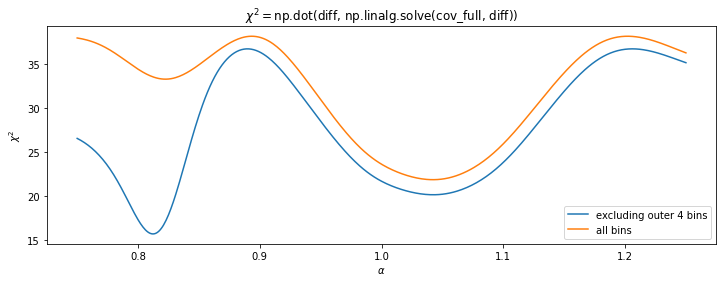

In [72]:
# plot chi_squareds as a function of alpha
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(alpha_grid, chi_squareds_cut, label=f'excluding outer {2*cut_size} bins')
ax.plot(alpha_grid, chi_squareds, label=f'all bins')
ax.set_title(f'$\chi^2 = $np.dot(diff, np.linalg.solve(cov_full, diff))')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^2$')
plt.legend()

print(f"best alpha: {alpha_grid[chi_squareds.argmin()]}")
print("bao alpha: {:.2f}".format(bao_alpha))

In [75]:
def exclude_bins(cut_size, rlz, cat_tag, nbins=nbins, nmocks=nmocks, data_dir=data_dir):
    # binned results
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_ls = ls_results[1]
    
    r_avg_cut = r_avg[cut_size:nbins-cut_size]
    xi_ls_cut = xi_ls[cut_size:nbins-cut_size]
    nbins_cut = len(r_avg_cut)
    
    # covariance matrices
    xi_lss_cut = np.empty((nmocks, nbins_cut))
    xi_lss = np.empty((nmocks, nbins))
    for rlz in range(nmocks):
        ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
        
        r_avg_cut = ls_results[0][cut_size:nbins-cut_size]
        xi_lss_cut[rlz] = ls_results[1][cut_size:nbins-cut_size]
        
        r_avg = ls_results[0]
        xi_lss[rlz] = ls_results[1]

    cov_cut = np.cov(xi_lss_cut.T)
    cov = np.cov(xi_lss.T)
    
    # performing the fit
    alpha_grid = np.linspace(0.75, 1.25, 501)
    xi_fits = np.empty((len(alpha_grid), nbins))
    xi_fits_cut = np.empty((len(alpha_grid), nbins_cut))
    chi_squareds_cut = np.ones(len(alpha_grid))
    chi_squareds = np.ones(len(alpha_grid))
    for i in range(len(alpha_grid)):
        # excluding bins
        xi_fit_cut, M_cut = fit_to_cf_model(alpha_grid[i], xi_ls_cut, r_avg_cut, cov_cut)
        xi_fits_cut[i] = xi_fit_cut
        diff_cut = xi_ls_cut - xi_fit_cut
        chi_squared_cut = np.dot(diff_cut, np.linalg.solve(cov_cut, diff_cut))
        chi_squareds_cut[i] = chi_squared_cut

        # full bins
        xi_fit, M = fit_to_cf_model(alpha_grid[i], xi_ls, r_avg, cov)
        xi_fits[i] = xi_fit
        diff = xi_ls - xi_fit
        chi_squared = np.dot(diff, np.linalg.solve(cov, diff))
        chi_squareds[i] = chi_squared

    # plot chi_squareds as a function of alpha
    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(alpha_grid, chi_squareds_cut/(nbins_cut), label=f'excluding outer {2*cut_size} bins')
    ax.plot(alpha_grid, chi_squareds/(nbins), label=f'all bins')
    ax.set_title(f'{cat_tag} lognormal, rlz {rlz}: $\chi^2 = $np.dot(diff, np.linalg.solve(cov_full, diff))')
    ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^2$')
    plt.legend()

    print(f"best alpha, excluding outer {2*cut_size} bins: {alpha_grid[chi_squareds_cut.argmin()]}")
    print(f"best alpha, all bins: {alpha_grid[chi_squareds.argmin()]}")

best alpha, excluding outer 4 bins: 0.812
best alpha, all bins: 1.042
best alpha, excluding outer 4 bins: 1.046
best alpha, all bins: 1.047
best alpha, excluding outer 4 bins: 0.837
best alpha, all bins: 0.985
best alpha, excluding outer 4 bins: 1.039
best alpha, all bins: 0.813
best alpha, excluding outer 4 bins: 0.995
best alpha, all bins: 0.998


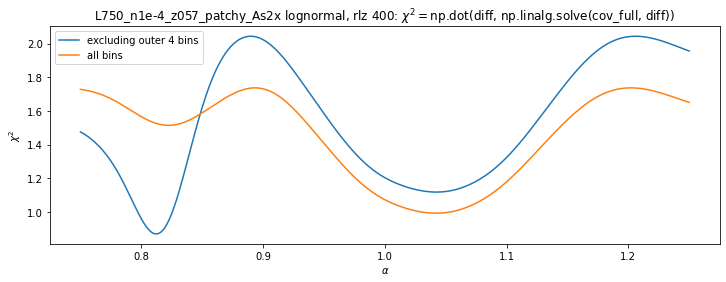

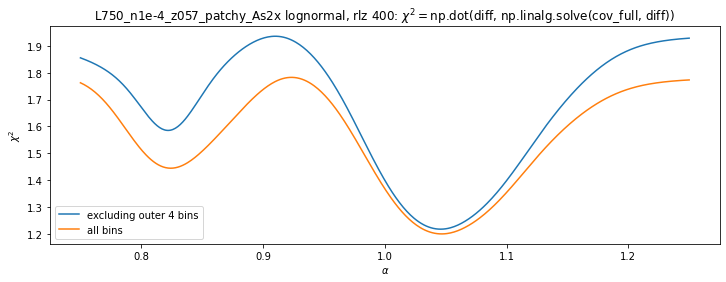

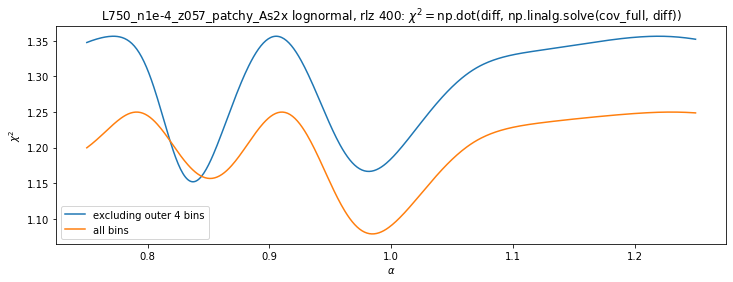

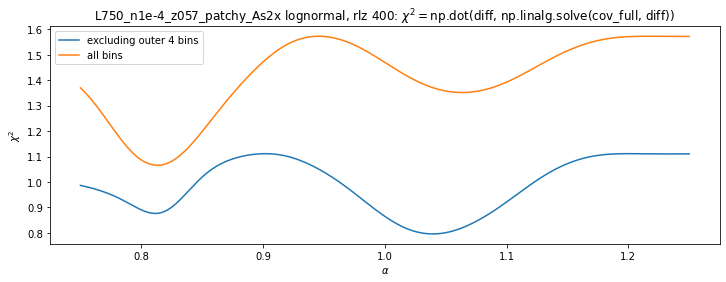

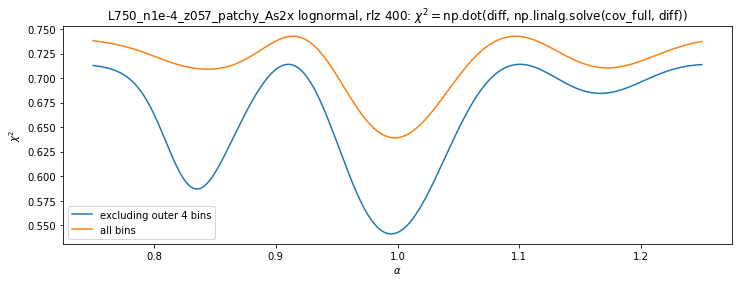

In [76]:
for rlz in range(5):
    exclude_bins(2, rlz, cat_tag)